In [1]:
## General Libraries
import pandas as pd
import numpy as np
from collections import Counter
import warnings

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
warnings.filterwarnings("ignore")

## evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_recall_curve, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

## Classifier
from sklearn.ensemble import RandomForestClassifier

#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2, mutual_info_classif

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

pd.set_option('display.max_columns', None)

In [2]:
# add full path to csv
df = pd.read_csv("Telco_Customer_Churn.csv")

In [3]:
df = df.drop("customerID", axis=1)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.fillna(0)

In [4]:
def filter_columns(df):
    columns_str = []
    columns_num = []
    
    for col in columns:
        if is_numeric_dtype(df[col]):
            columns_num.append(col)
        else:
            columns_str.append(col)
    return columns_str, columns_num

In [5]:
## grouping columns for encoding
multi_val_cols = ["Contract", "PaymentMethod"]
yes_no_cols = ["gender","Partner","Dependents", "PhoneService", "PaperlessBilling", 'Churn']
services = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

columns = list(df.columns)
categorical_features = []
numerical_features = []
categorical_features , numerical_features = filter_columns(df)

#removing churn
categorical_features = [element for element in categorical_features if element != "Churn"]
del columns


# Helper Functions

In [6]:
# All yes/no columns can be encoded normally, but we will only drop the first column
def encode_columns():
    global df
    global yes_no_cols
    global multi_val_cols
    global services
    
    for col in yes_no_cols:
        temp = pd.get_dummies(df[col], drop_first=True)
        df = pd.concat([df, temp], axis=1)
        df.rename(columns = {'Yes':f"Yes_{col}"}, inplace=True)
        df = df.drop(col, axis=1)

    #  All multivalue columns will be encoded normally , but we will not drop the first columns , since all its values
    #  provide usefull information
    for col in multi_val_cols:
        temp = pd.get_dummies(df[col])
        df = pd.concat([df, temp], axis=1)
        df.rename(columns = {'Yes':f"Yes_{col}"}, inplace=True)
        

    #   All services have (yes/no/no_internet service), we will be dropping the last two columns,
    #   since the model can obtain the no column from the yes column(inverse), as for the internet service, 
    #   we will be getting it from the "InternetService " Column
    for col in services:
        temp = pd.get_dummies(df[col])
        df = pd.concat([df, temp], axis=1)
        df.rename(columns = {'Yes':f"Yes_{col}"}, inplace=True)
        df = df.drop("No", axis=1)

    df = df.drop("No internet service", axis=1)

    ## Encoding "InternetService" Column
    temp = pd.get_dummies(df["InternetService"])
    df = pd.concat([df, temp], axis = 1)
    df.rename(columns = {"No": "No Internet"}, inplace=True)

    ## Encoding "MultipleLines" Column
    temp = pd.get_dummies(df["MultipleLines"])
    df = pd.concat([df, temp], axis = 1)
    df.rename(columns = {"No": "No_MultipleLines"}, inplace=True)
    df.rename(columns = {"Yes": "Yes_MultipleLines"}, inplace=True)

    # Getting rid of all the previous,  not encoded columns
    df = df.drop(["InternetService", "MultipleLines"], axis=1)
    df = df.drop(services, axis=1)
    df = df.drop(multi_val_cols, axis=1)
    del temp

In [7]:
def save_model(file_name, model):
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)

### Model Evaluation helper functions

In [8]:
def report(model_name, y_test, y_pred):
    print (f"{model_name} Report")
    print (confusion_matrix(y_test, y_pred))
    print (classification_report(y_test, y_pred))
    print ("-"*50)


def apply_threshold_on_model(positive_probabilities, threshold):
    return np.where(positive_probabilities>threshold, 1, 0)

def find_best_threshold(model, model_name):
    global x_test
    global y_test
    # plotting recall-precision curve
    y_pred_prob = model.predict_proba(x_test)
    prec , recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
    area = round(auc(recall, prec), 2)
    print (f"AveragePrecision = {area}")
    plt.plot(prec, recall)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
    #finding best threshold for best f1 score
    best_f1_score = 0
    best_threshold = 0
    probabilities = y_pred_prob[:,1]
    for threshold in thresholds:
        y_pred_adjusted = apply_threshold_on_model(probabilities, threshold)
        recall = recall_score(y_test, y_pred_adjusted)
        precision = precision_score(y_test, y_pred_adjusted)
        f1 = 2*(recall*precision)/(recall+precision)
        if f1 > best_f1_score:
            best_f1_score = f1
            best_threshold = threshold

        
    print (f"Best F1 score for {model_name} = {best_f1_score}")
    print (f"best threshold for {model_name} = {best_threshold}")
    return best_threshold
    
def plot_roc_auc(model_name, y_test, positive_probabilty_predictions):
    print (f"{model_name} ROC_AUC Curve ")
    auc = roc_auc_score(y_test, positive_probabilty_predictions)
    false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, positive_probabilty_predictions)

    plt.figure(figsize=(10, 8), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'g')
    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightblue', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()


In [9]:
# Simple memory/space management
encode_columns()
df['SeniorCitizen'] = df['SeniorCitizen'].astype('int8')
df['MonthlyCharges'] = df['MonthlyCharges'].astype('float16')
df['tenure'] = df['tenure'].astype('int8')

# Feature selection

In [10]:
colors = ['#0070ff','#ffdf00']
#selecting Categorical Features
features = df.drop(numerical_features, axis=1)
features = features.drop("Yes_Churn", axis=1)
churn = df["Yes_Churn"]

### SelecKBest using chi2

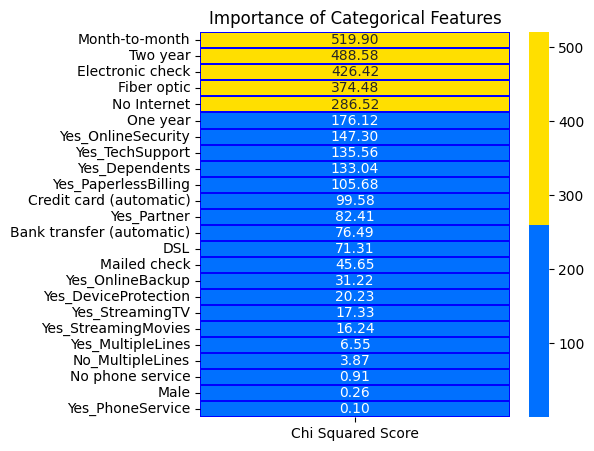

In [11]:
#SelectKBest
important_features = SelectKBest(score_func = chi2, k = "all")
fit = important_features.fit(features,churn)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,
            linewidths = 0.2,linecolor = 'blue',fmt = '.2f');
plt.title('Importance of Categorical Features');

### Recursive Feature Elimination (RFE) using RandomForestClassifier

In [12]:
x = df.drop('Yes_Churn', axis=1)
y = df['Yes_Churn']

rfe_selector = RFE(estimator=RandomForestClassifier(criterion='entropy',max_depth=10), n_features_to_select=20, 
                   step=1, verbose=1)
rfe_selector.fit(x, y)
rfe_support = rfe_selector.get_support()
rfe_feature = x.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print (rfe_feature)

Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
20 selected features
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Male', 'Yes_Partner', 'Yes_Dependents', 'Yes_PaperlessBilling', 'Month-to-month', 'One year', 'Two year', 'Electronic check', 'Yes_OnlineSecurity', 'Yes_TechSupport', 'Yes_StreamingTV', 'Yes_StreamingMovies', 'DSL', 'Fiber optic', 'No Internet', 'No_MultipleLines']


In [13]:
x_rfe = df[rfe_feature]
y= df["Yes_Churn"]

print (x.shape)
print (x_rfe.shape)
print (y.shape)
print (y.value_counts())

(7043, 28)
(7043, 20)
(7043,)
0    5174
1    1869
Name: Yes_Churn, dtype: int64


# Fitting and Testing

In [14]:
# lets split data first , to isolate our test data
x_train , x_test , y_train , y_test = train_test_split(x, y, test_size=0.2,random_state=1)

#### Balancing Dataset

In [15]:
x_new , y_new = RandomOverSampler(random_state = 0, sampling_strategy=0.8).fit_resample(x_train,y_train)
#SMOTE
print (f"Original Disturbution {Counter(y_train)}")
print (f"after oversampling disturbution = {Counter(y_new)}")

Original Disturbution Counter({0: 4113, 1: 1521})
after oversampling disturbution = Counter({0: 4113, 1: 3290})


#### Instantiating RandomForestClassifier()
1) Fitting 

2) Saving the model

In [16]:
weights_rfc = {0:1, 1:1.5}
rfc = RandomForestClassifier(criterion='gini', max_depth=8, class_weight=weights_rfc)
rfc.fit(x_new, y_new)

## S
save_model("ChurnTrained.clf", rfc)

print (f"RandomOverSampler Training Score: {round(rfc.score(x_new, y_new),5)}")

RandomOverSampler Training Score: 0.82791


In [17]:
y_pred = rfc.predict(x_test)
report("RFC", y_test, y_pred)

RFC Report
[[773 288]
 [ 56 292]]
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1061
           1       0.50      0.84      0.63       348

    accuracy                           0.76      1409
   macro avg       0.72      0.78      0.72      1409
weighted avg       0.83      0.76      0.77      1409

--------------------------------------------------


### Plotting Precission/Recall Curve
1) Finding optimal threshold for best f1 score using function "find_best_threshold"

AveragePrecision = 0.67


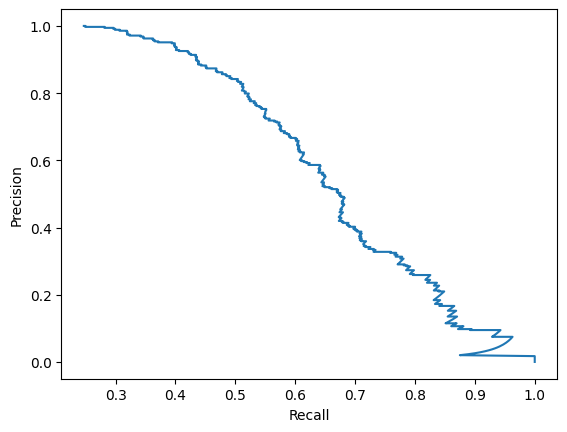

Best F1 score for RFC_ROS = 0.6366950182260024
best threshold for RFC_ROS = 0.630249024115622


In [18]:
optimal_threshold = find_best_threshold(rfc, "RFC_ROS")

# Predicting probabilities

RFC_ROS ROC_AUC Curve 


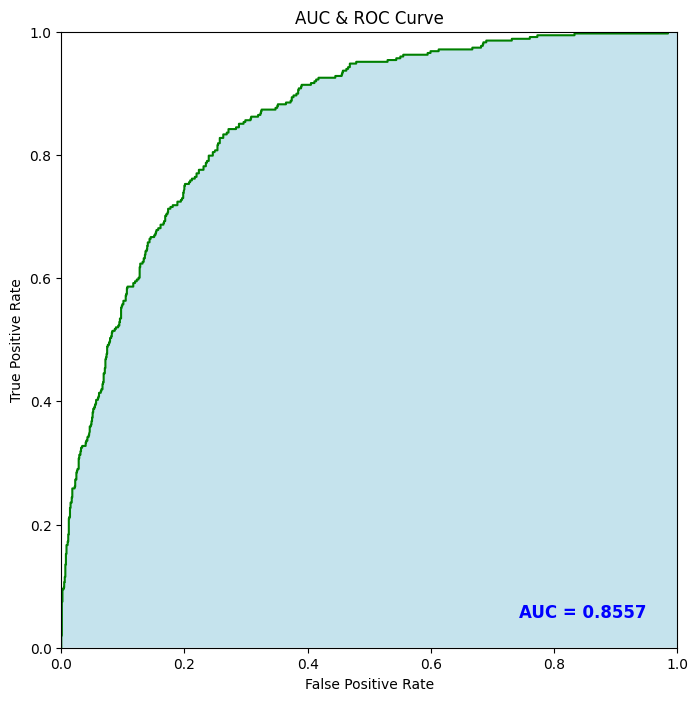

In [19]:
probabilities = rfc.predict_proba(x_test)
probabilities_positive = probabilities[:, 1]
plot_roc_auc("RFC_ROS", y_test, probabilities_positive)

# !!OPTIONAL THRESHOLD TUNING!!

In [20]:
### Optional Threshold Tuning
y_pred_adjusted = apply_threshold_on_model(probabilities_positive, 0.2)
report("RFCadjusted", y_test, y_pred_adjusted)

RFCadjusted Report
[[450 611]
 [ 13 335]]
              precision    recall  f1-score   support

           0       0.97      0.42      0.59      1061
           1       0.35      0.96      0.52       348

    accuracy                           0.56      1409
   macro avg       0.66      0.69      0.55      1409
weighted avg       0.82      0.56      0.57      1409

--------------------------------------------------
